Now that we have combined multiple datasets into a single dataset, we want to visualize the data to note any abnormalities in the data, and also convert categorical variables into dummy variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.testing

In [2]:
df = pd.read_csv('data/ICU_combined.csv')

In [3]:
len(df)

45054

In [4]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'ETHNICITY_WHITE',
       'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN',
       'ETHNICITY_NATIVE', 'ADMISSION_NUM', 'GENDER', 'ICUSTAY_NUM', 'AGE',
       'ICD_BINS_18', 'ICD_BINS_1', 'ICD_BINS_2', 'ICD_BINS_3', 'ICD_BINS_4',
       'ICD_BINS_5', 'ICD_BINS_6', 'ICD_BINS_7', 'ICD_BINS_8', 'ICD_BINS_9',
       'ICD_BINS_10', 'ICD_BINS_11', 'ICD_BINS_12', 'ICD_BINS_13',
       'ICD_BINS_14', 'ICD_BINS_15', 'ICD_BINS_16', 'ICD_BINS_17',
       'COMORBID_TOTAL', 'ABNORMAL_EVENTS_TOTAL'],
      dtype='object')

## LOS

max LOS: 173.07
min LOS: 0.00


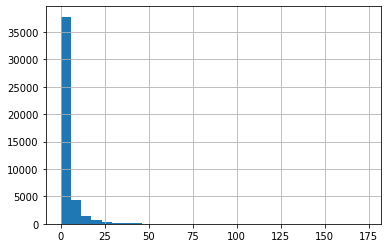

In [5]:
print('max LOS: %.2f' % df['LOS'].max())
print('min LOS: %.2f' % df['LOS'].min())
df['LOS'].hist(bins = 30)

Note that this is very skewed. If using a linear model, we'll have to transform it. (log, boxcox or tukey transforms could work: https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0

However, since we're going to use XGBoost, we'll leave it since regression trees are non-linear

In [6]:
df['LOS'].nlargest(10)

11363    173.0725
11778    153.9280
18952    116.8327
19208    104.2483
40136    101.7390
19813    100.1225
22433     98.8877
2796      98.6446
7213      97.4897
17879     91.5726
Name: LOS, dtype: float64

## ICD Codes - comorbidities

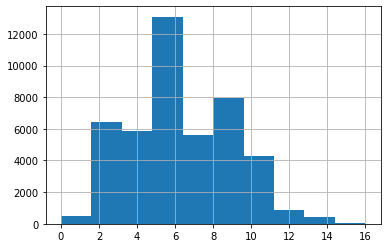

In [7]:
df['COMORBID_TOTAL'].hist()

## Age

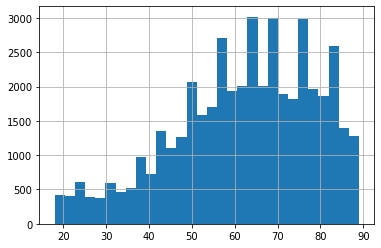

In [8]:
df['AGE'].hist(bins = 30)

In [9]:
print('max age: %.2f' % df['AGE'].max())
print('min age: %.2f' % df['AGE'].min())

max age: 89.00
min age: 18.00


## Admissions

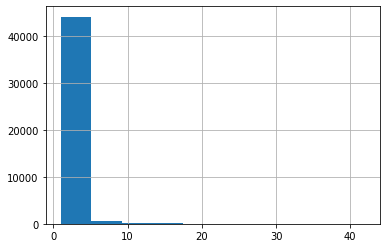

In [10]:
df['ADMISSION_NUM'].hist()

In [11]:
df['ADMISSION_NUM'].nlargest(10)

10832    42
10831    41
10830    40
10829    39
10828    38
10827    37
10826    36
10825    35
10438    34
10824    34
Name: ADMISSION_NUM, dtype: int64

## ICU Stays

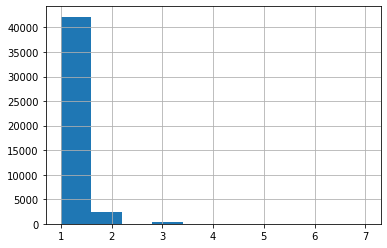

In [12]:
df['ICUSTAY_NUM'].hist()

In [13]:
df['ICUSTAY_NUM'].nlargest(10)

12979    7
23415    7
4863     6
12978    6
23414    6
35144    6
4862     5
12977    5
21244    5
22310    5
Name: ICUSTAY_NUM, dtype: int64

In [14]:
#df[df['ICUSTAY_NUM']>=6]

__IMPORTANT:__ Because each person has the possibility of being admitted to the ICU >1, we need to take care of this carefully when we split the data into train/test sets, because we don't want to leak any of the data from the same people onto both sides.

## Total abnormal events

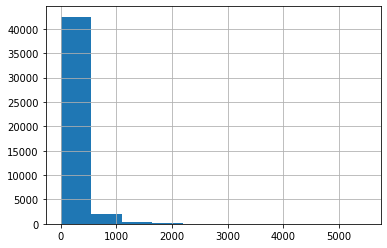

In [15]:
df['ABNORMAL_EVENTS_TOTAL'].hist()

In [16]:
df['ABNORMAL_EVENTS_TOTAL'].nlargest(10)

11362    5480
11363    5480
11778    4417
31773    4191
31774    4191
31775    4191
31776    4191
31777    4191
43381    4145
43382    4145
Name: ABNORMAL_EVENTS_TOTAL, dtype: int64

## Admission Types & Location

use one hot encoding for admission types and location, dropping 'info not available' column

In [17]:
df['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

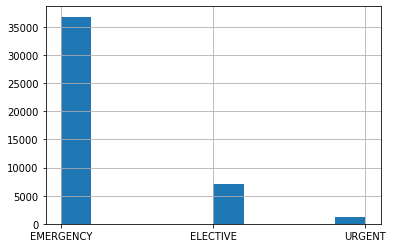

In [18]:
df['ADMISSION_TYPE'].hist()

In [19]:
# create dummy variables "ADMISSION_EMERGENCY", "ADMISSION_ELECTIVE", etc
admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION', prefix_sep = '_')
df = df.join(admissions)
df.drop(['ADMISSION_TYPE'], axis = 1, inplace = True)

In [20]:
df['ADMISSION_LOCATION'].unique()

array(['EMERGENCY ROOM ADMIT', 'PHYS REFERRAL/NORMAL DELI',
       'TRANSFER FROM HOSP/EXTRAM', 'CLINIC REFERRAL/PREMATURE',
       'TRANSFER FROM SKILLED NUR', 'TRANSFER FROM OTHER HEALT',
       'HMO REFERRAL/SICK', '** INFO NOT AVAILABLE **',
       'TRSF WITHIN THIS FACILITY'], dtype=object)

In [21]:
# look at the number of people for each admission location
df.groupby(['ADMISSION_LOCATION'])['SUBJECT_ID'].count()

ADMISSION_LOCATION
** INFO NOT AVAILABLE **         3
CLINIC REFERRAL/PREMATURE     8999
EMERGENCY ROOM ADMIT         19482
HMO REFERRAL/SICK                1
PHYS REFERRAL/NORMAL DELI     8600
TRANSFER FROM HOSP/EXTRAM     7714
TRANSFER FROM OTHER HEALT       63
TRANSFER FROM SKILLED NUR      187
TRSF WITHIN THIS FACILITY        5
Name: SUBJECT_ID, dtype: int64

In [22]:
df['ADMISSION_LOCATION'].replace(' ', '_', regex=True, inplace = True)

In [23]:
admit_location = pd.get_dummies(df['ADMISSION_LOCATION'], prefix = 'ADMIT_LOCATION', prefix_sep = '_')

In [24]:
# drop ones that don't have a lot of data
admit_location.drop(['ADMIT_LOCATION_**_INFO_NOT_AVAILABLE_**','ADMIT_LOCATION_HMO_REFERRAL/SICK','ADMIT_LOCATION_TRSF_WITHIN_THIS_FACILITY'], axis = 1, inplace = True)

In [25]:
df = df.join(admit_location)
df.drop(['ADMISSION_LOCATION'], axis = 1,inplace = True)

## Insurance

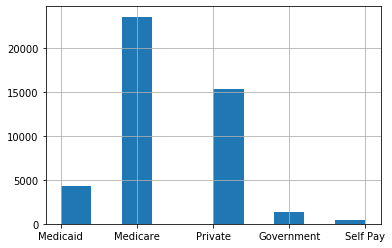

In [26]:
df['INSURANCE'].hist()

In [27]:
df['INSURANCE'].replace(' ','_', regex = True, inplace = True)

In [28]:
insurance = pd.get_dummies(df['INSURANCE'], prefix = 'INSURANCE', prefix_sep = '_')
df = df.join(insurance)
df.drop(['INSURANCE'], axis = 1, inplace = True)

## Gender

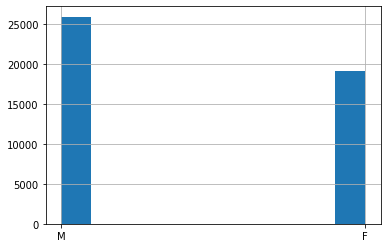

In [29]:
df['GENDER'].hist()

In [30]:
gender = pd.get_dummies(df['GENDER'])
df = df.join(gender)
df.drop(['GENDER'], axis = 1, inplace = True)

In [31]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME',
       'ETHNICITY_WHITE', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO',
       'ETHNICITY_ASIAN', 'ETHNICITY_NATIVE', 'ADMISSION_NUM', 'ICUSTAY_NUM',
       'AGE', 'ICD_BINS_18', 'ICD_BINS_1', 'ICD_BINS_2', 'ICD_BINS_3',
       'ICD_BINS_4', 'ICD_BINS_5', 'ICD_BINS_6', 'ICD_BINS_7', 'ICD_BINS_8',
       'ICD_BINS_9', 'ICD_BINS_10', 'ICD_BINS_11', 'ICD_BINS_12',
       'ICD_BINS_13', 'ICD_BINS_14', 'ICD_BINS_15', 'ICD_BINS_16',
       'ICD_BINS_17', 'COMORBID_TOTAL', 'ABNORMAL_EVENTS_TOTAL',
       'ADMISSION_ELECTIVE', 'ADMISSION_EMERGENCY', 'ADMISSION_URGENT',
       'ADMIT_LOCATION_CLINIC_REFERRAL/PREMATURE',
       'ADMIT_LOCATION_EMERGENCY_ROOM_ADMIT',
       'ADMIT_LOCATION_PHYS_REFERRAL/NORMAL_DELI',
       'ADMIT_LOCATION_TRANSFER_FROM_HOSP/EXTRAM',
       'ADMIT_LOCATION_TRANSFER_FROM_OTHER_HEALT',
       'ADMIT_LOCATION_TRANSFER_FROM_SKILLED_NUR', 'INSURANCE_Government',
       'INSURANCE_Medicaid', 'I

In [32]:
df.to_csv('data/ICU_preprocessed.csv', index=False) 